In [5]:
import mitsuba as mi
import drjit as dr
import numpy as np
from sionna.rt import load_scene, Transmitter, Receiver, Camera, RadioMapSolver, PathSolver
import matplotlib.pyplot as plt

In [6]:
mi.set_variant("llvm_ad_mono_polarized")

In [7]:
import sionna.rt as rt

In [ ]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
# concrete for floor/walls, metal for roofs
scene = load_scene(scene_path)

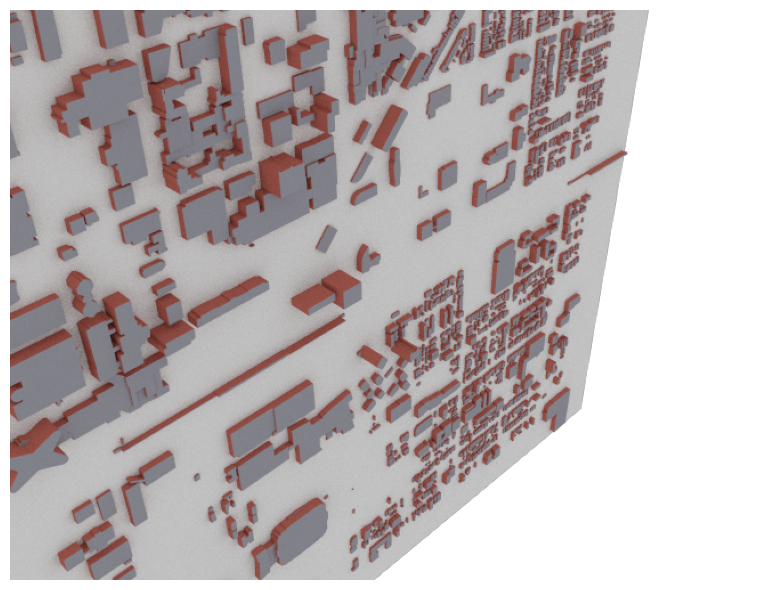

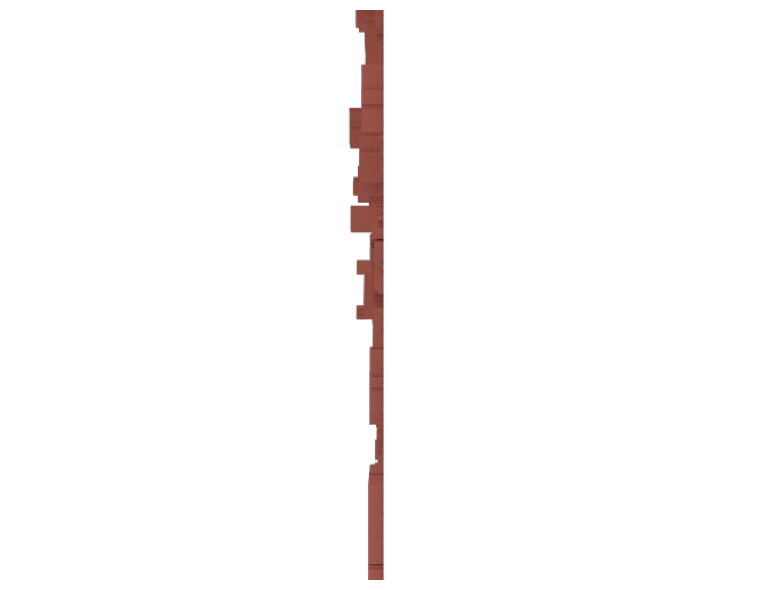

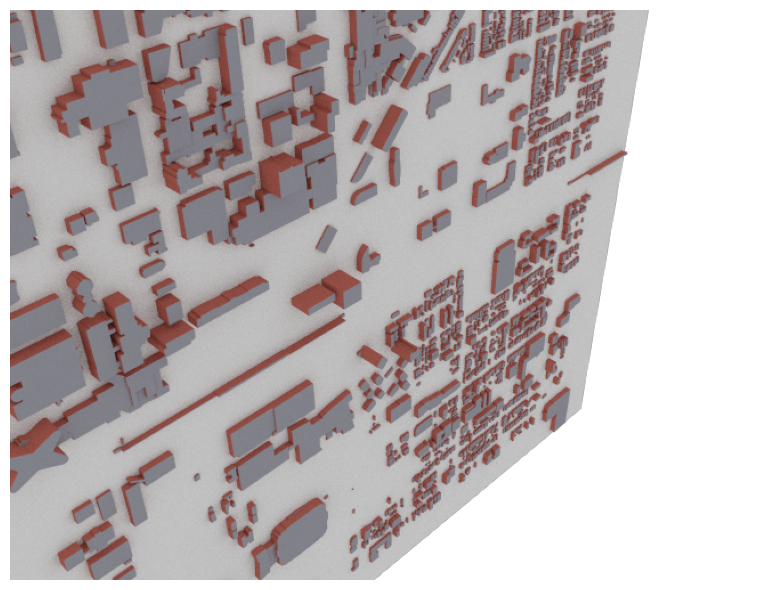

In [9]:
overhead = Camera(position=(0.0, 0.0, 2000.0))
overhead.look_at((0.0,0.0,0.0))
scene.render(camera=overhead)

isometric = Camera(position=(1200.0, 1200.0, 1200.0))
isometric.look_at((0.0,0.0,0.0))
scene.render(camera=isometric)

# Camera on render should be Z up, Y forwards!

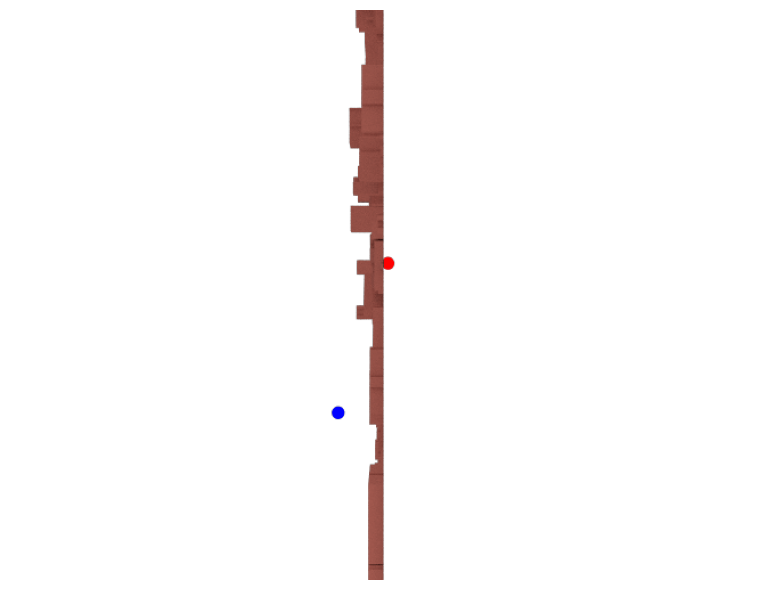

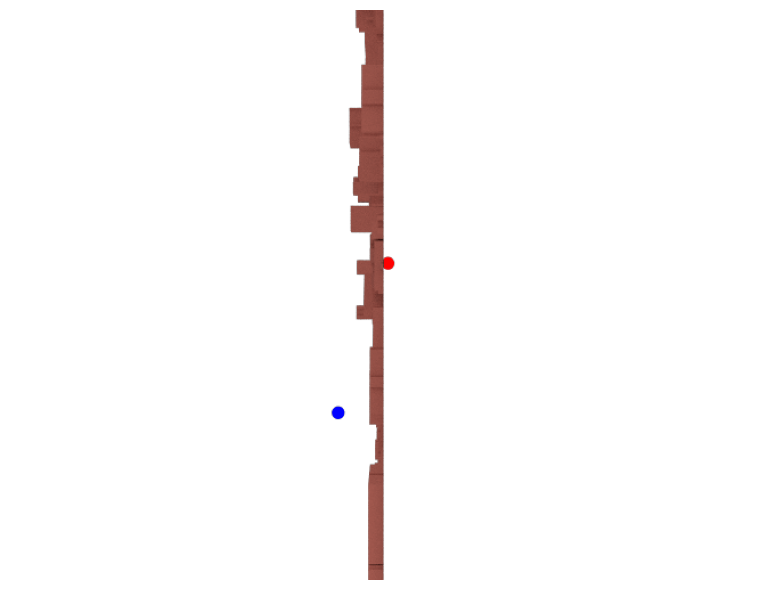

In [10]:
# Set up antenna arrays
scene.tx_array = rt.PlanarArray(num_rows=2, num_cols=1, pattern="iso", polarization="V")
scene.rx_array = rt.PlanarArray(num_rows=1, num_cols=1, pattern="iso", polarization="V")

# Add Transmitter
tx = Transmitter(name="Tx1", position=[70,-10,10], color=[1.0, 0.0, 0.0])
scene.add(tx)


tx_2 = Transmitter(name="Tx2", position=[-260,100,10], color=[0.0, 0.0, 1.0])
scene.add(tx_2)


# Visualize scene with transmitter and receivers in place
cam = Camera(position=(0.0, 0.0, 2000.0))
cam.look_at((0.0, 0.0, 0.0)) 
scene.render(camera=cam)

In [11]:
x_min, x_max = -500, 500
y_min, y_max = -500, 500
z_height = 10
cell_size = (20, 20)

map_width = x_max - x_min
map_height = y_max - y_min
map_center = [(x_min + x_max) / 2, (y_min + y_max) / 2, z_height]

rm_solver = RadioMapSolver()

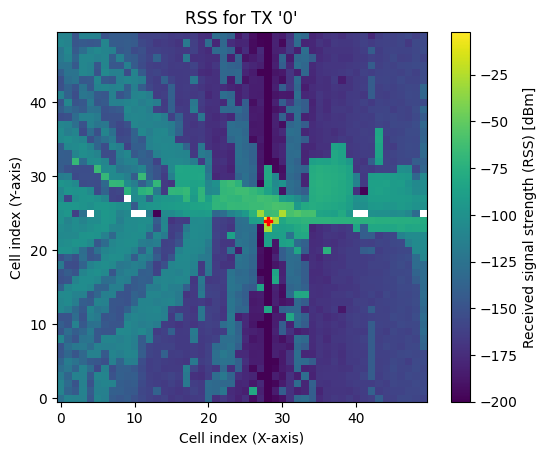

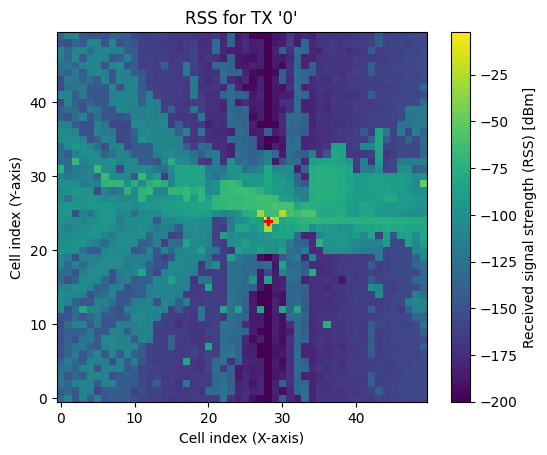

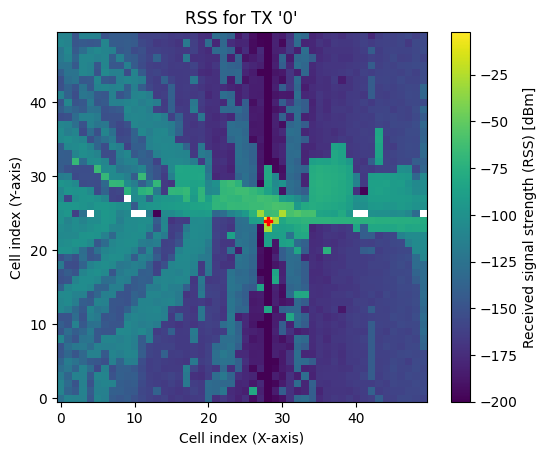

In [12]:
rm = rm_solver(
    scene,
    max_depth=25,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

# RM with max depth 3 for comparison
rm_3 = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True,
)

rm.show(metric="rss", tx=0, show_tx=True, vmin=-200)
rm_3.show(metric="rss", tx=0, show_tx=True, vmin=-200)

# rss = np.array(rm.rss)
# print(f"{np.log(rss)}")

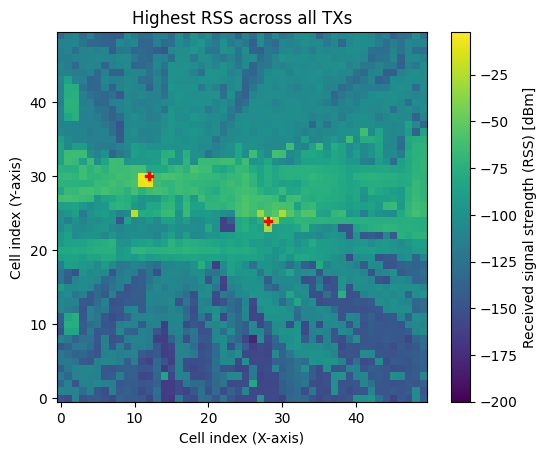

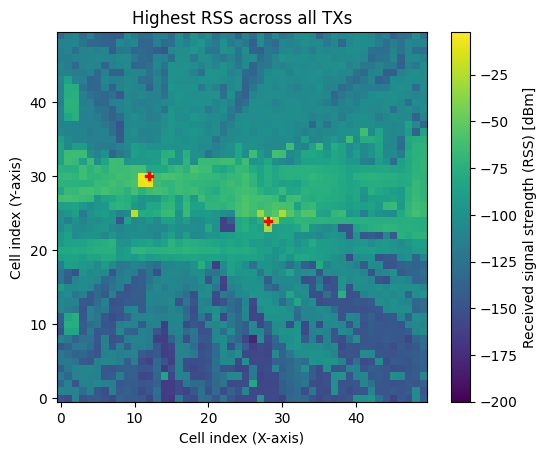

In [13]:
rm_2tx = rm_solver(
    scene,
    max_depth=3,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**7,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
)

rm_2tx.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [14]:
scene.preview(radio_map=rm, rm_vmin=-160)

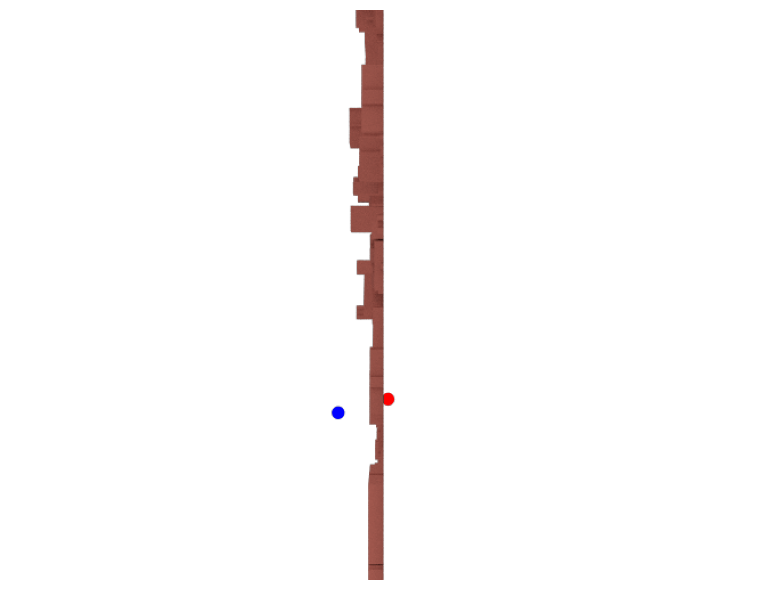

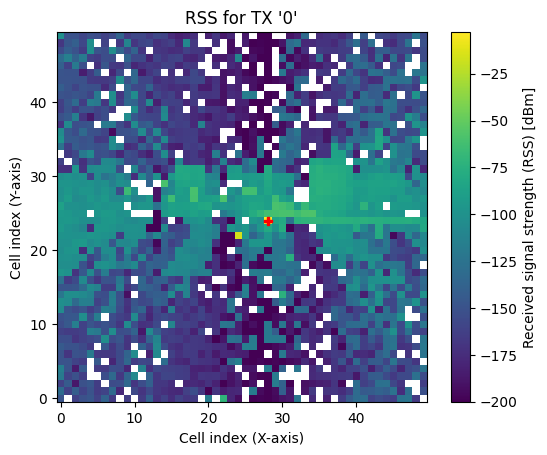

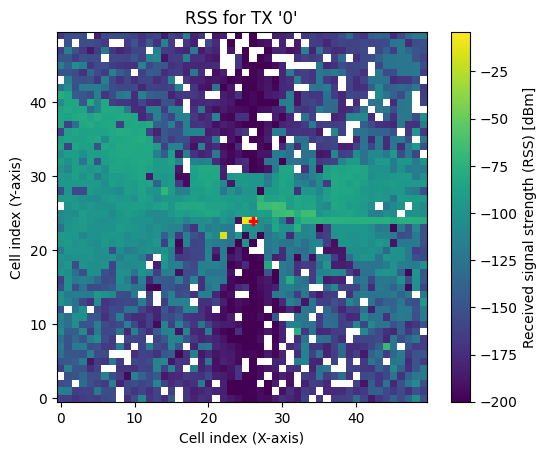

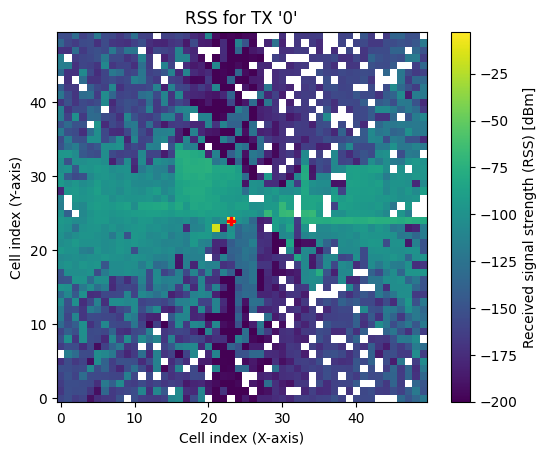

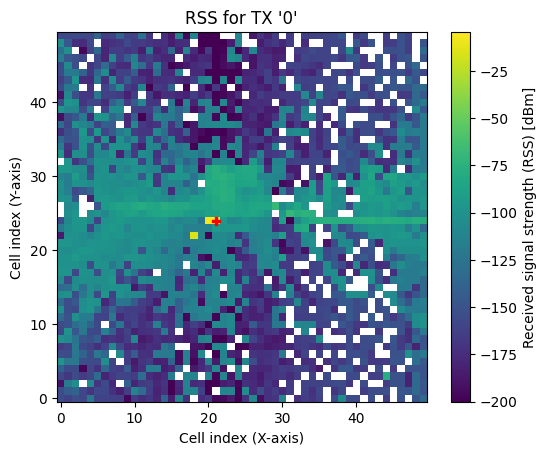

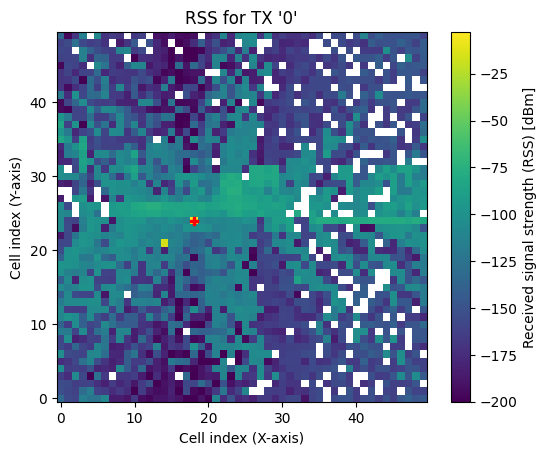

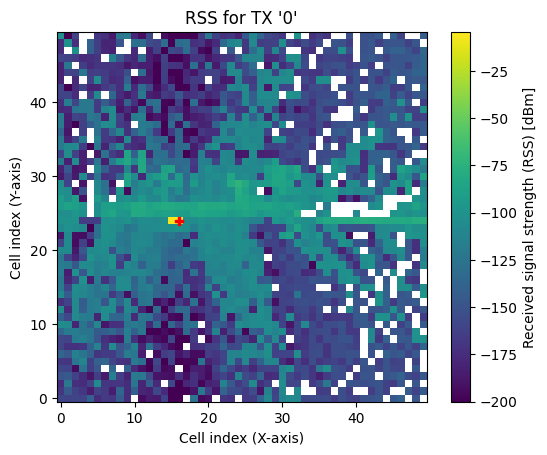

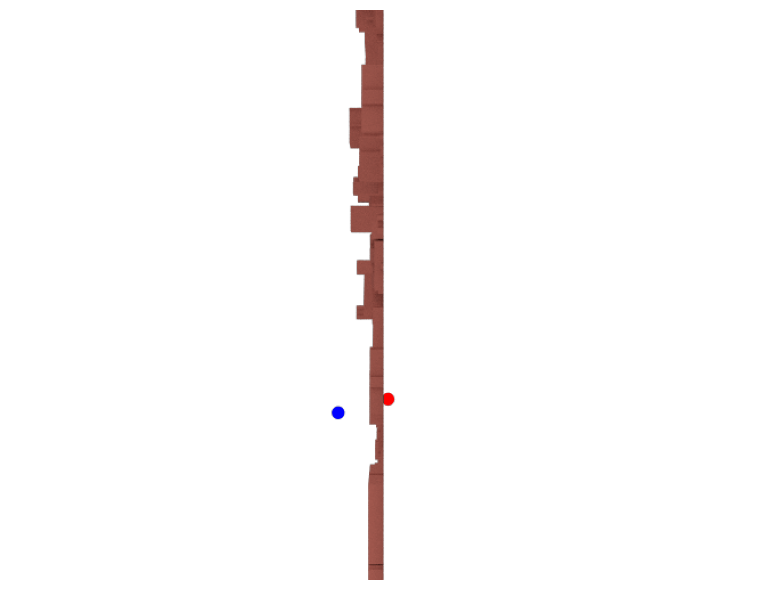

In [15]:
# --------------------------Moving Transmitters----------------------------#

displacement_vec = [50, 0, 0]
num_displacements = 5

for _ in range(num_displacements+1):
    rm_mobile = rm_solver(
    scene,
    max_depth=10,                   # Maximum number of ray-scene interactions (subject to change)
    samples_per_tx=10**6,           # More samples = less noise but more memory
    cell_size=cell_size,            # Resolution of the radio map
    center=map_center,              # Center of the coverage area
    size=[map_width, map_height],   # Total size of the radio map
    orientation=[0, 0, 0],          # Horizontal orientation (Z-up)
    diffraction=True,
    refraction=True,
    edge_diffraction=True
    ) 
    
    scene.get("Tx1").position -= displacement_vec
    rm_mobile.show(metric="rss", tx=0, show_tx=True, vmin=-200)

    
scene.render(camera=cam)

In [16]:
print(scene.get("Chicago_Water_Tower-itu_concrete").mi_mesh.bbox())

# when iterating, 


AttributeError: 'NoneType' object has no attribute 'mi_mesh'

In [17]:
# Check all 5 objects and their bbox sizes
for name in scene.objects.keys():
    try:
        bbox = scene.get(name).mi_mesh.bbox()
        min_pt = bbox.min
        max_pt = bbox.max
        size_x = max_pt[0] - min_pt[0]
        size_y = max_pt[1] - min_pt[1]
        size_z = max_pt[2] - min_pt[2]
        print(f"{name}:")
        print(f"  Size: {size_x:.1f} x {size_y:.1f} x {size_z:.1f} m")
        print(f"  Min: [{min_pt[0]:.1f}, {min_pt[1]:.1f}, {min_pt[2]:.1f}]")
        print(f"  Max: [{max_pt[0]:.1f}, {max_pt[1]:.1f}, {max_pt[2]:.1f}]")
        print()
    except Exception as e:
        print(f"{name}: ERROR - {e}\n")

no-name-1:
  Size: 1896.5 x 70.2 x 1951.7 m
  Min: [-985.3, 0.0, -975.7]
  Max: [911.2, 70.2, 976.0]

no-name-2:
  Size: 1896.5 x 66.2 x 1951.7 m
  Min: [-985.3, 4.0, -975.7]
  Max: [911.2, 70.2, 976.0]

elm__4273:
  Size: 2000.0 x 0.0 x 2000.0 m
  Min: [-1000.0, 0.0, -1000.0]
  Max: [1000.0, 0.0, 1000.0]

